# Imports

In [1]:
import pandas as pd
import os
import pylab as plt
import numpy as np

import seaborn as sns

import gitsu_analytics as ga

%matplotlib inline
plt.style.use(ga.settings.STYLESHEET_FILEPATH)


In [2]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 20

In [3]:
class Crayons:
    dark_grey = '#5E5E5E'
    grey = '#919191'
    light_grey = '#C0C0C0'    
    dark_red = '#941100'
    dark_blue = '#005493'
    yellow = '#FEC139'
    green = '#009051'
    
crayons = Crayons() 
crayons.__dict__.update({k.replace(' ', '_').lower(): v for k, v in sns.colors.crayons.items()})

# Globals

# Data

## df_issues

In [95]:
query = """
SELECT 
  iss.*
  , creator.user_name AS issue_user_name
FROM 
    github_issue iss
    LEFT JOIN github_user creator ON 
        creator.user_ext_id = iss.issue_user_ext_id

WHERE
    NOT iss.issue_is_pull_request
    --AND iss.issue_repo_id = 'gutenburg' -- TODO: need to fix this....

"""
df_issues = ga.db_execute(query)

2019-02-18T00:43:29 50 database  :L169 INFO     | query returned 6715 rows in 0:00:00.328497


In [96]:
df_issues['issue_created_at_date'] = df_issues['issue_created_at'].dt.date
df_issues['issue_closed_at_date'] = df_issues['issue_closed_at'].dt.date
df_issues['issue_updated_at_date'] = df_issues['issue_updated_at'].dt.date

## df_events

In [97]:
query = """
SELECT 
    e.* 
    , u.user_name AS event_actor_username
FROM
    github_issue_event e
    JOIN github_issue iss ON iss.issue_ext_id = e.event_issue_ext_id
    LEFT JOIN github_user u ON u.user_ext_id = e.event_user_ext_id
WHERE
    NOT iss.issue_is_pull_request
"""
df_events = ga.db_execute(query)

2019-02-18T00:43:31 50 database  :L169 INFO     | query returned 48326 rows in 0:00:01.109491


In [98]:
df_events['event_created_at_date'] = df_events['event_created_at'].dt.date 

In [99]:
# df = ga.db_execute("""
# select * from data_lake
# WHERE
#     schema='github_issue_event'
# LIMIT 10

# """)

In [100]:
df_events.groupby('event').size().sort_values()

event
unlocked                        2
pinned                          4
unpinned                        4
locked                          7
unsubscribed                    9
converted_note_to_issue        21
marked_as_duplicate            25
comment_deleted                28
removed_from_project           92
unassigned                    160
reopened                      217
moved_columns_in_project      418
added_to_project              419
renamed                       990
demilestoned                 1171
assigned                     1397
referenced                   1419
unlabeled                    1727
milestoned                   2416
closed                       5806
mentioned                    8914
subscribed                   9160
labeled                     13920
dtype: int64

## df_actor_issues_closed

In [101]:
df_actor_issues_closed = (
    df_events
    .query('event == "closed"')    
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()
    
)

## df_day_issues

In [193]:
def calc_day_issues(df_issues):
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_created_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_created_cnt'] = gb.size()
    df_day_created = df    
    
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_closed_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_closed_cnt'] = gb.size()
    df_day_closed = df    
    
    #################################################
    gb = (
        df_issues
        .groupby([
            'issue_updated_at_date',
        ])
    )
    df = pd.DataFrame()
    df['issues_updated_cnt'] = gb.size()
    df_day_updated = df  
    
    #################################################
    df = (
        df_day_created
        .merge(
            df_day_closed,
            how='outer',
            left_index=True,
            right_index=True,
        )
        .merge(
            df_day_updated,
            how='outer',
            left_index=True,
            right_index=True,
        )  
        .sort_index()
    )
    idx = pd.date_range(
        df.index.min(),
        df.index.max(),
    )

    df_day_issues = (
        df
        .reindex(idx)
        .fillna(0)
    )  
    return df_day_issues

In [194]:
df_day_issues = calc_day_issues(df_issues)

In [195]:
df_day_issues['issues_created_cnt_cuml'] = df_day_issues['issues_created_cnt'].cumsum()
df_day_issues['issues_closed_cnt_cuml'] = df_day_issues['issues_closed_cnt'].cumsum()
df_day_issues['issues_open'] = df_day_issues['issues_created_cnt_cuml'] - df_day_issues['issues_closed_cnt_cuml']

df_day_issues['issues_unupdated'] = df_day_issues['issues_created_cnt_cuml'] - df_day_issues['issues_updated_cnt'].cumsum()


In [196]:
df_day_issues['issues_labeled_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .query('event == "labeled"')
    .groupby('event_created_at_date')
    ['event_issue_ext_id']
    .nunique()
)

In [197]:
df_day_issues['issues_effected_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .groupby('event_created_at_date')
    ['event_issue_ext_id']
    .nunique()
)

In [198]:
df_day_issues['events_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .groupby('event_created_at_date')
    .size()
)

In [199]:
df_day_issues['issues_closed_by_designsimply'] = (
    df_events
    .query('event_actor_username == "designsimply"')
    .query('event == "closed"')
    .groupby('event_created_at_date')
    .size()
)

# Analyze

In [200]:
DESIGNSIMPLY_START_DATE = pd.Timestamp('2018-06-25').date()
DESIGNSIMPLY_END_DATE = pd.Timestamp('2019-01-11').date()

def plot_designsimply_start_date(**kws):
    defaults = dict(
         alpha=0.8,    
        color='#68D7EE',
        ls='--',
        label='designsimply {}'.format(DESIGNSIMPLY_START_DATE.isoformat()),
    )
    defaults.update(kws)
    plt.axvline(DESIGNSIMPLY_START_DATE, **defaults)

    
    defaults = dict(
        alpha=0.8,    
        color='#68D7EE',
        ls='--',
        label='designsimply {}'.format(DESIGNSIMPLY_END_DATE.isoformat()),
    )
    defaults.update(kws)
    plt.axvline(DESIGNSIMPLY_END_DATE, **defaults)
    
    

In [201]:
def plot_attrs_time():
    plt.gca().xaxis.set_major_locator(
        plt.matplotlib.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1)
    )
    plt.gca().xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter('%b %Y')
    )
    plt.xlabel('')
    plt.xticks(rotation=35, ha='right')
    

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## Events Loaded

In [190]:
number_of_unloaded_events = df_issues['issue_events_last_loaded_at'].isnull().sum()
print('{} issues without loaded events'.format(number_of_unloaded_events))

0 issues without loaded events


## Issues Created/Closed

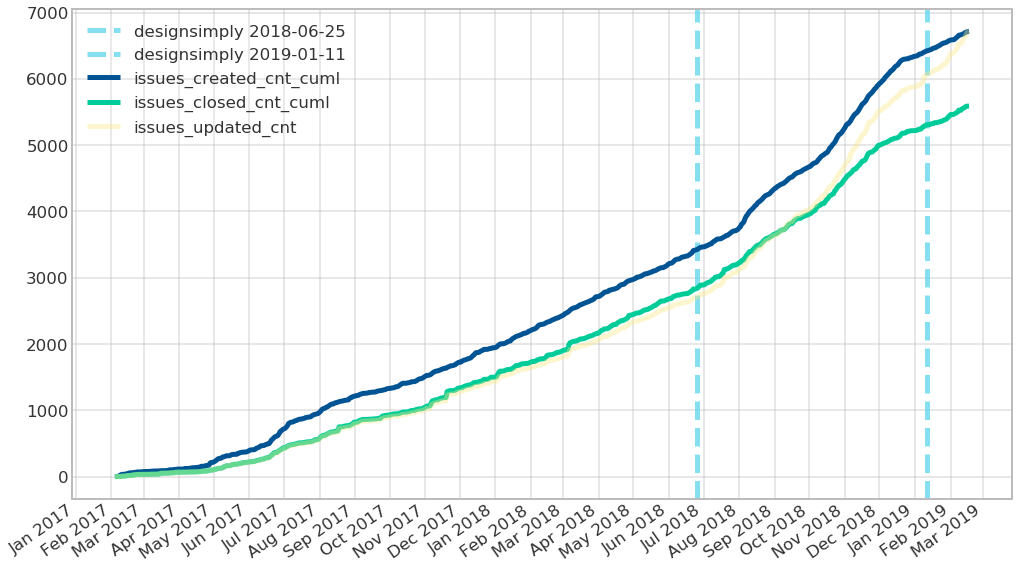

In [114]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()

df_day_issues['issues_created_cnt_cuml'].plot(
    color=crayons.dark_blue,
)
df_day_issues['issues_closed_cnt_cuml'].plot(
    color=crayons.caribbean_green,

)
df_day_issues['issues_updated_cnt'].cumsum().plot(
    color=crayons.yellow,
    alpha=0.4,

)
plt.legend()
plot_attrs_time()

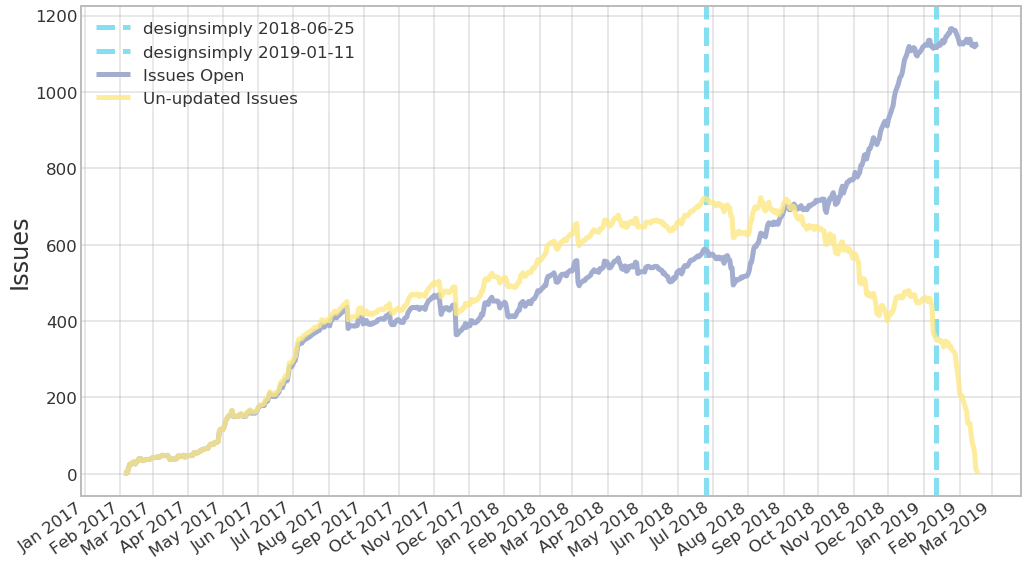

In [115]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()
df_day_issues['issues_open'].plot(
    label='Issues Open',
    color=crayons.wild_blue_yonder,
)

df_day_issues['issues_unupdated'].plot(
    label='Un-updated Issues',
    color=crayons.yellow,
    alpha=0.8,
)

# df_day_issues['issues_closed_by_designsimply'].fillna(0).cumsum().plot(
#     label='Issues closed by designsimply',
# )


plt.legend(loc=2)
plt.ylabel('Issues')
plot_attrs_time()

## Issues Created/Closed Per Day

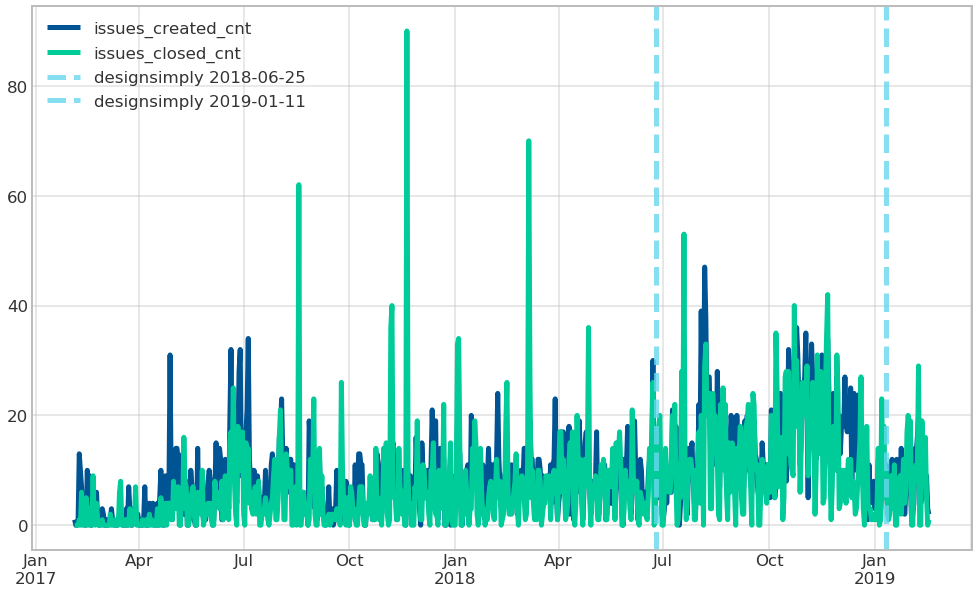

In [116]:
plt.figure(figsize=(15, 10))
df_day_issues['issues_created_cnt'].plot(
    color=crayons.dark_blue,
)
df_day_issues['issues_closed_cnt'].plot(
    color=crayons.caribbean_green,
)
#df_day_issues['issues_updated_cnt'].plot()
plot_designsimply_start_date()
plt.legend()


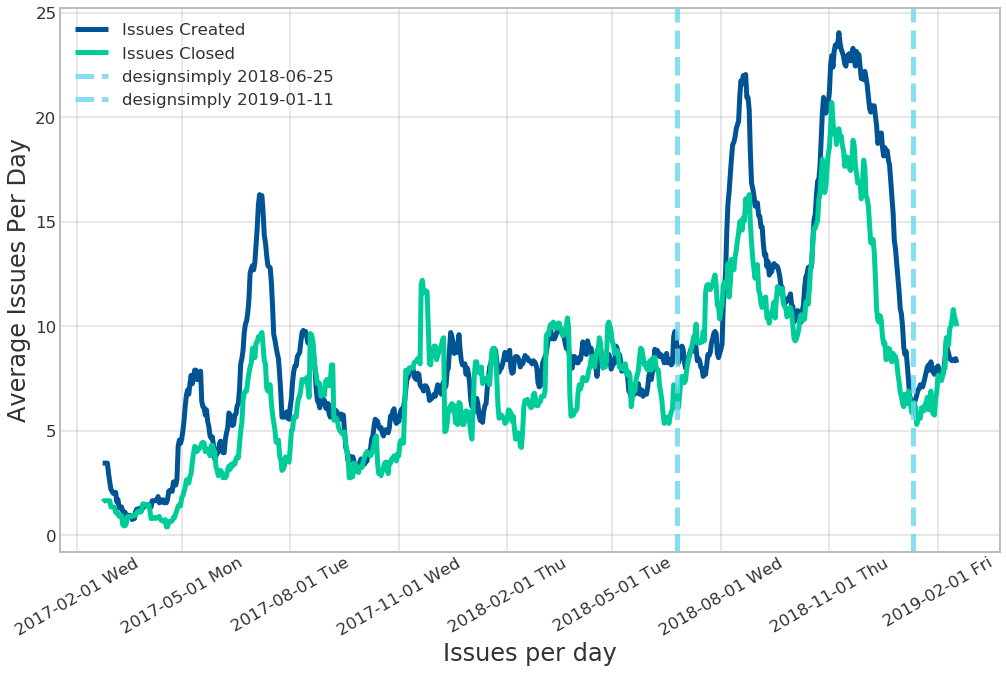

In [117]:
plt.plot(
    df_day_issues.index,
    df_day_issues['issues_created_cnt'].rolling(20).mean(),
    label='Issues Created',
    color=crayons.dark_blue,    
)

plt.plot(
    df_day_issues.index,
    df_day_issues['issues_closed_cnt'].rolling(20).mean(),
    label='Issues Closed',
    color=crayons.caribbean_green,    
)

plt.xlabel('Issues per day')

#plt.xlim(pd.Timestamp('2018-07-25'), pd.Timestamp('2018-08-15'))

plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%Y-%m-%d %a')
)
plt.ylabel('Average Issues Per Day')
#plt.axvline(pd.Timestamp('2018-08-02'))
plot_designsimply_start_date()
plt.xticks(rotation=30)
plt.legend()
#plot_attrs_time()

## Issues Closed All Time

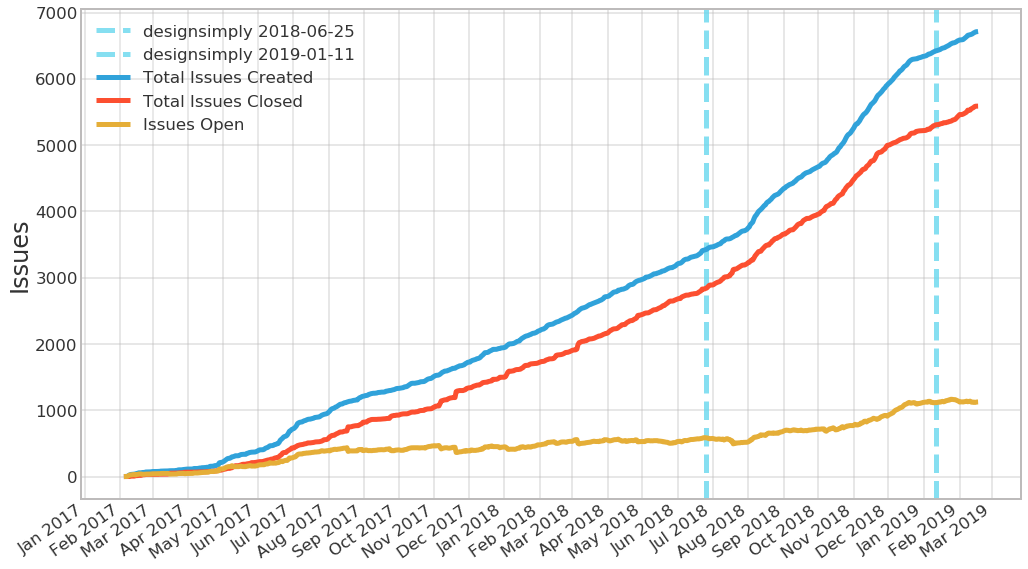

In [118]:
plt.figure(figsize=(15, 10))

plot_designsimply_start_date()

df_day_issues['issues_created_cnt_cuml'].plot(
    #color=crayons.dark_blue,
    label='Total Issues Created',
)
df_day_issues['issues_closed_cnt_cuml'].plot(
    #color=crayons.b_pink,
    label='Total Issues Closed',
)
df_day_issues['issues_open'].plot(
    label='Issues Open',
    #color=crayons.dark_grey,
)


plt.legend(loc=2)
plt.ylabel('Issues')
plot_attrs_time()

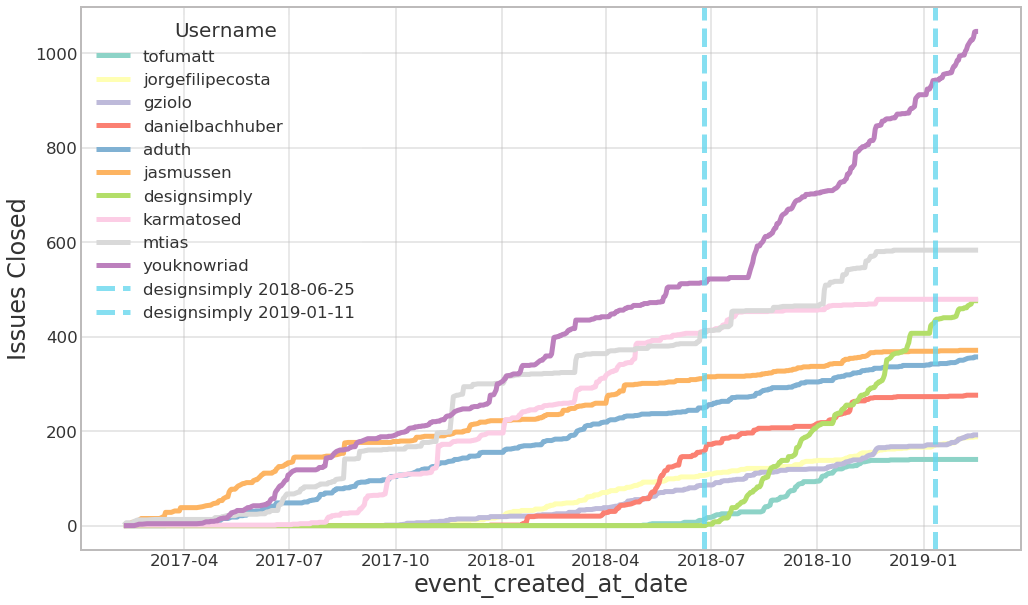

In [119]:
top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

(
    df_actor_issues_closed
    .loc[:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username')
plt.ylabel('Issues Closed')
plt.show()

In [120]:
print('\n\n\nLeaderboard for Closed Issues All Time ')
(
    df_events
    .query('event == "closed"')
    .groupby('event_actor_username')
    ['event_issue_ext_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .to_frame('issues_closed')

)




Leaderboard for Closed Issues All Time 


,issues_closed
event_actor_username,
youknowriad,1039
mtias,579
karmatosed,475
designsimply,471
jasmussen,368
aduth,350
danielbachhuber,273
gziolo,188
jorgefilipecosta,187


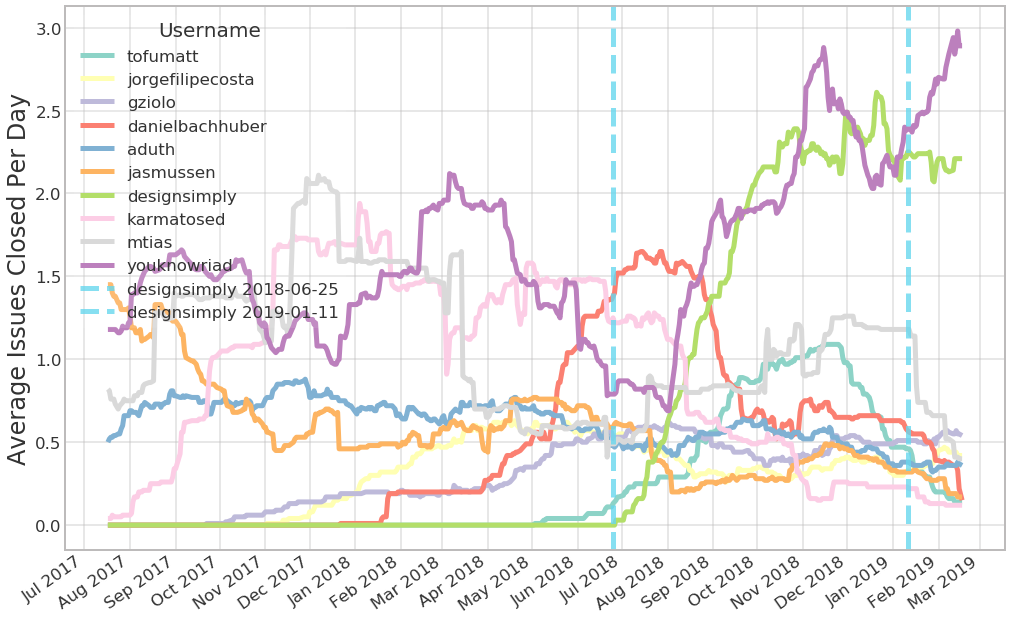

In [121]:

top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .fillna(0)
    .loc[:, top_actors.index]
    .rolling(100)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Average Issues Closed Per Day')
plot_attrs_time()

In [122]:
df_actor_all_time = pd.DataFrame()
df_actor_all_time['avg_closed_per_day'] = df_actor_issues_closed.mean()
df_actor_all_time['p75_closed_per_day'] = df_actor_issues_closed.quantile(0.75)
df_actor_all_time['std_closed_per_day'] = df_actor_issues_closed.std()
df_actor_all_time['contribution_days'] = df_actor_issues_closed.count()
(
    df_actor_all_time
    .query('contribution_days > 50')
    .sort_values('avg_closed_per_day', ascending=False)
    .head(10)
)

,avg_closed_per_day,p75_closed_per_day,std_closed_per_day,contribution_days
event_actor_username,,,,
mtias,4.255474,4.00,8.596365,137
designsimply,3.661538,4.75,3.281505,130
youknowriad,3.440789,4.00,3.617401,304
karmatosed,3.397163,3.00,5.041088,141
danielbachhuber,2.760000,3.25,2.539068,100
jasmussen,2.234940,2.00,2.548722,166
tofumatt,2.028986,2.00,1.653615,69
aduth,1.750000,2.00,1.244198,204
gziolo,1.669565,2.00,1.065584,115


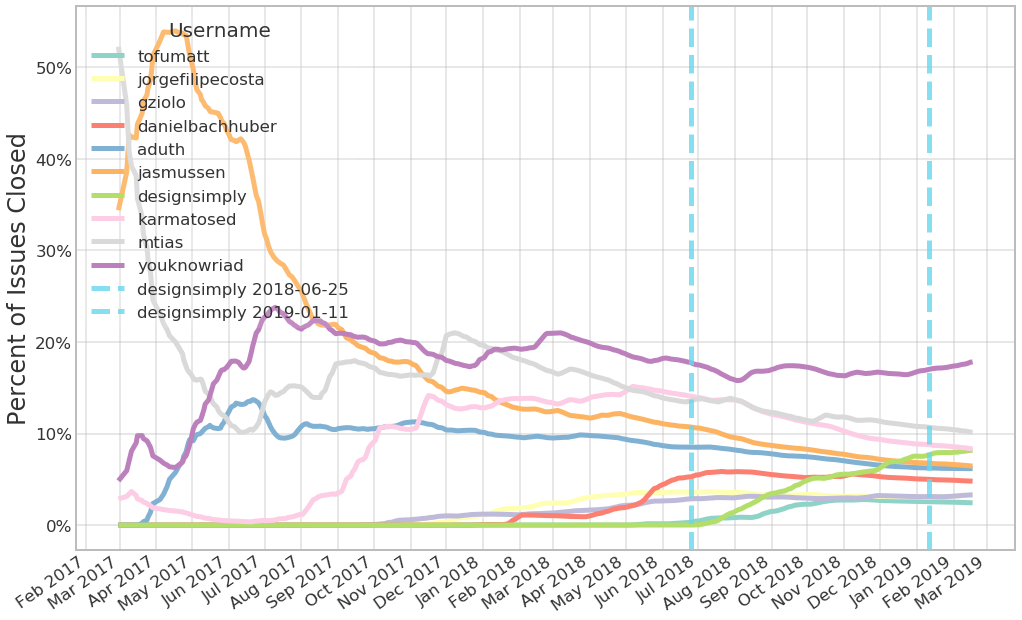

In [123]:

top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .fillna(0)
    .cumsum(axis=0)
)
df_actor_issues_closed_pct = (
    (values.T / values.sum(axis=1)).T
)
(
    df_actor_issues_closed_pct
    .loc[:, top_actors.index]
    .rolling(10)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plt.xlabel('')
plot_attrs_time()

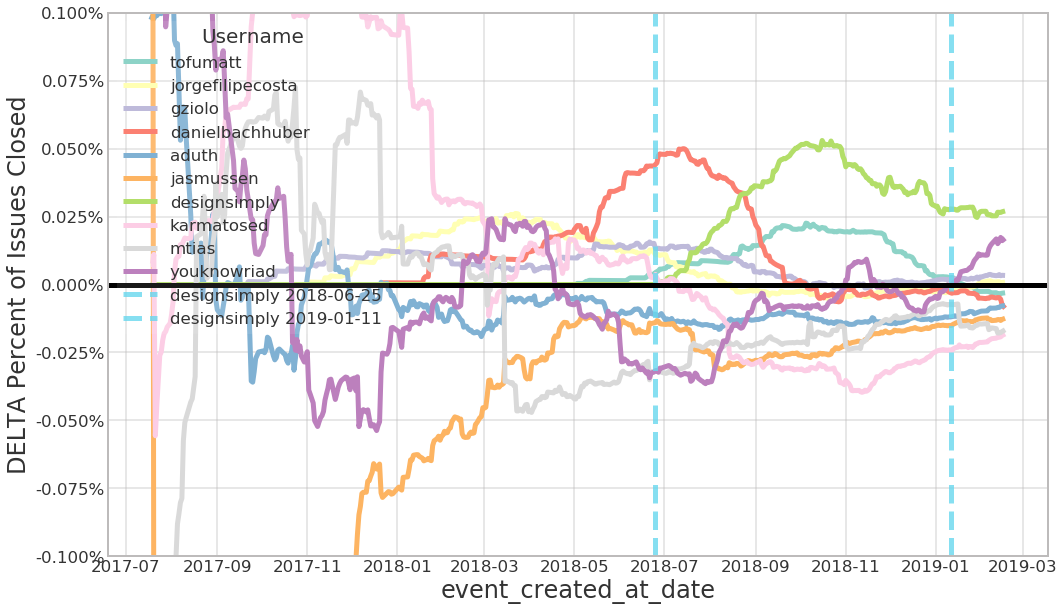

In [124]:
(
    df_actor_issues_closed_pct
    .loc[:,top_actors.index]
    .diff() 
    .rolling(100)
    .mean()    
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()

plt.axhline(0, color='k')
plt.legend(loc=2, title='Username')
plt.ylim(-0.001, 0.001)
plt.ylabel('DELTA Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.3%}'))


## Issues Closed designsimply

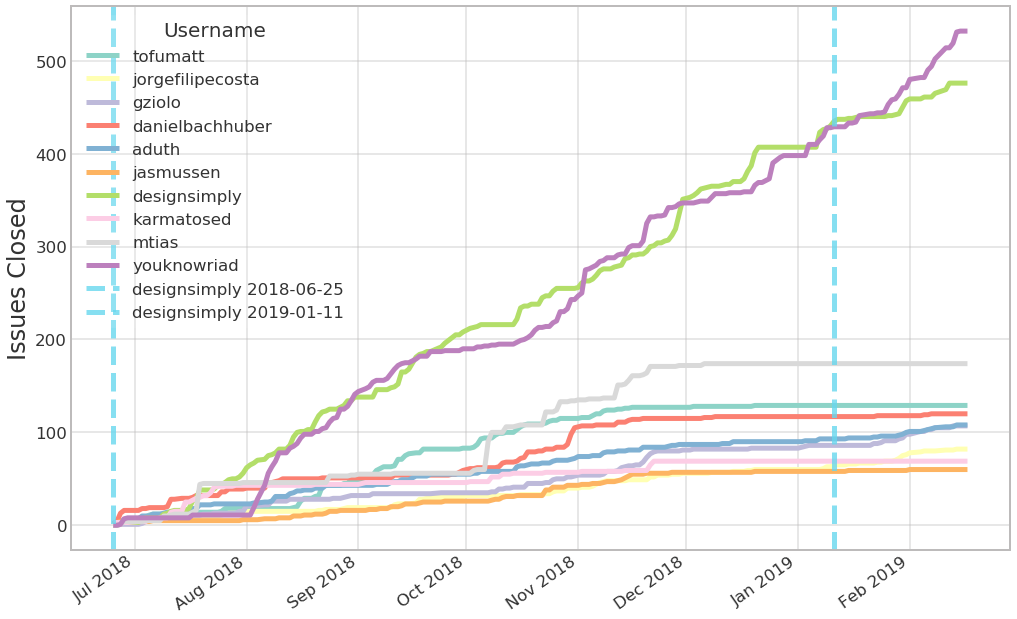

In [125]:
top_actors = df_actor_issues_closed.sum().sort_values()[-10:]

(
    df_actor_issues_closed
    .loc[DESIGNSIMPLY_START_DATE:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()


plt.legend(loc=2, title='Username')
plt.ylabel('Issues Closed')
plot_attrs_time()

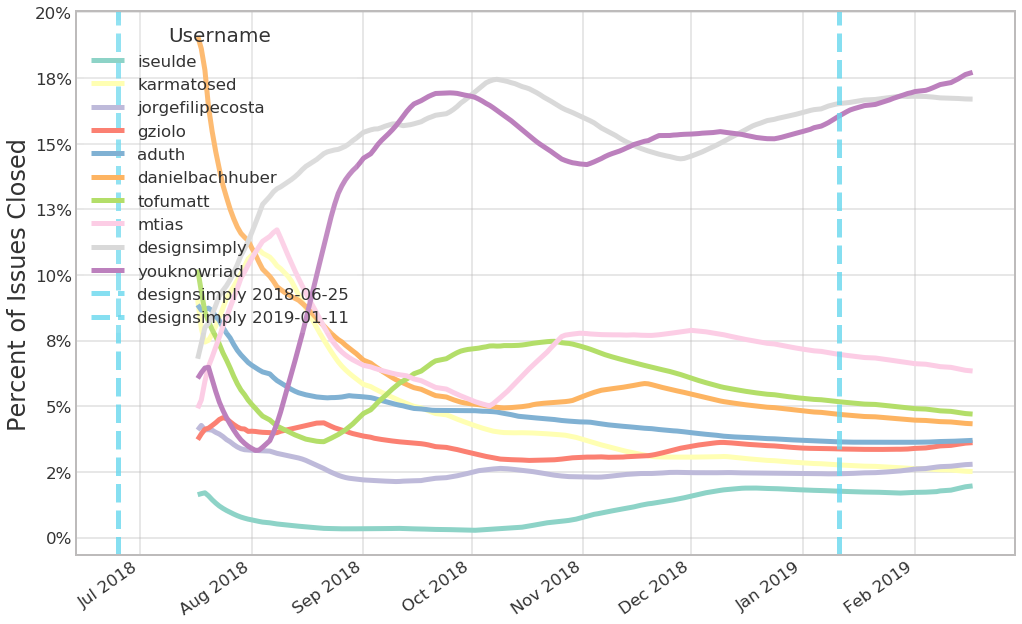

In [126]:
top_actors = df_actor_issues_closed.loc[DESIGNSIMPLY_START_DATE:,].sum().sort_values()[-10:]

values =(
    df_actor_issues_closed
    .loc[DESIGNSIMPLY_START_DATE:,]
    .fillna(0)
    .cumsum(axis=0)
)
df_actor_issues_closed_pct = (
    (values.T / values.sum(axis=1)).T
)
(
    df_actor_issues_closed_pct
    .loc[:, top_actors.index]
    .rolling(20)
    .mean()
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plot_designsimply_start_date()
plt.legend(loc=2, title='Username', fancybox=True)
plt.ylabel('Percent of Issues Closed')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plot_attrs_time()

## Issues Labeled

In [128]:
df_actor_issues_labeled = (
    df_events
    .query('event == "labeled"')
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()   
)

In [129]:
df_issues_labeled_cnt = (
    df_events
    .query('event == "labeled"')
    .groupby([
        'event_created_at_date',
    ])
    ['event_issue_ext_id']
    .nunique()
)

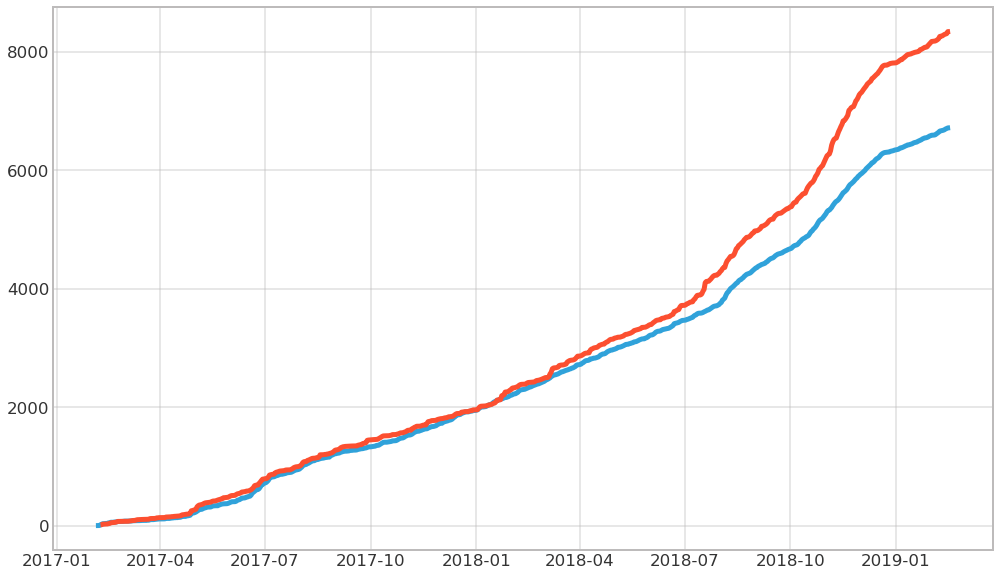

In [130]:
plt.figure()
plt.plot(
    df_day_issues.index,
    df_day_issues['issues_created_cnt_cuml'].values,
)

plt.plot(
    df_issues_labeled_cnt.index.astype(pd.Timestamp),
    df_issues_labeled_cnt.cumsum().values,
)


In [143]:
df = df_day_issues.describe().T
df['sum'] = df_day_issues.sum().T
df

,count,mean,std,min,25%,50%,75%,max,sum
issues_created_cnt,744.0,9.025538,7.517097,0.0,3.00,8.0,13.00,47.0,6715.0
issues_closed_cnt,744.0,7.512097,8.909134,0.0,1.00,5.0,10.00,90.0,5589.0
issues_updated_cnt,744.0,9.025538,11.020385,0.0,1.00,5.0,12.00,82.0,6715.0
issues_created_cnt_cuml,744.0,2649.510753,1995.438888,1.0,1063.00,2296.5,4090.75,6715.0,1971236.0
issues_closed_cnt_cuml,744.0,2144.178763,1717.951704,0.0,651.25,1776.5,3466.25,5589.0,1595269.0
issues_open,744.0,505.331989,289.338171,1.0,386.75,500.0,627.75,1166.0,375967.0
issues_unupdated,744.0,446.033602,209.967100,0.0,348.50,469.0,635.25,723.0,331849.0
issues_labeled_by_designsimply,158.0,12.050633,11.334968,1.0,3.25,9.0,17.75,79.0,1904.0
issues_effected_by_designsimply,176.0,13.284091,12.200655,1.0,4.00,11.0,20.00,84.0,2338.0
events_by_designsimply,176.0,30.056818,28.293304,1.0,8.00,22.5,44.00,170.0,5290.0


In [135]:
sub = (
    df_events
    [df_events['event_created_at'] > pd.Timestamp('2018-10-01T00:00:00Z')]
    .query('event == "labeled"')
)        
total_labeled_issues = sub['event_issue_ext_id'].nunique()
df = (
    sub
    .groupby(['event_actor_username'])
    ['event_issue_ext_id']
    .nunique()
    .sort_values(ascending=False)
    .to_frame('issues_labeled_cnt')
)
df['issues_labeled_percent'] = df['issues_labeled_cnt'] / total_labeled_issues
df[:10]

,issues_labeled_cnt,issues_labeled_percent
event_actor_username,,
designsimply,900,0.405771
swissspidy,418,0.188458
mtias,219,0.098738
Soean,176,0.079351
youknowriad,144,0.064923
afercia,104,0.046889
danielbachhuber,104,0.046889
iseulde,76,0.034265
earnjam,69,0.031109


## Issues Labeled designsimply

Text(0.5,0,'')

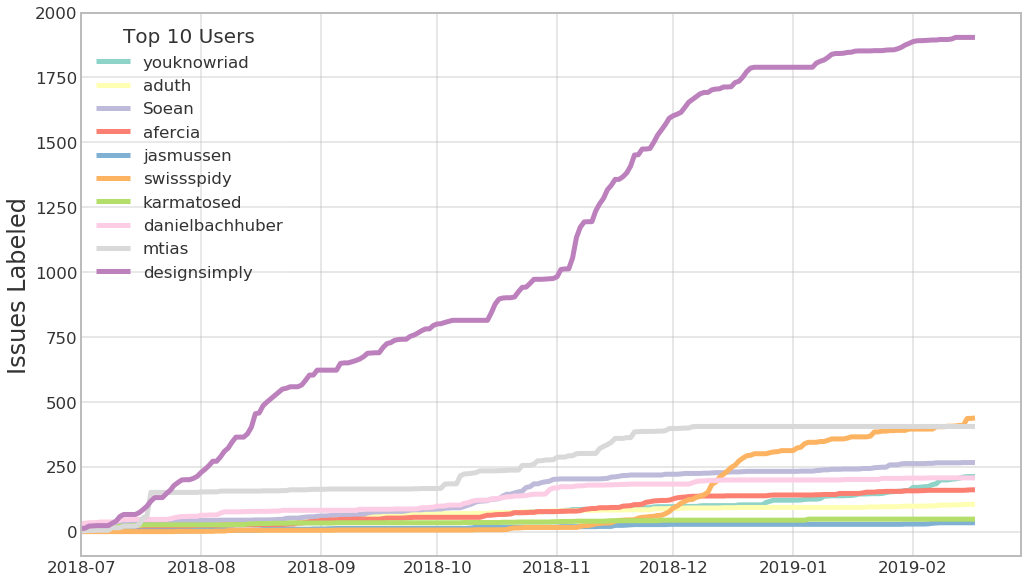

In [131]:
top_actors = df_actor_issues_labeled.sum().sort_values()[-10:]
(
    df_actor_issues_labeled
    .loc[DESIGNSIMPLY_START_DATE:
        , 
        top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,
    )
)
plt.legend(title='Top 10 Users')
plt.ylabel("Issues Labeled")
plt.xlim(pd.Timestamp('2018-07-01'), None)
plt.xlabel('')

## Events per day designsimply

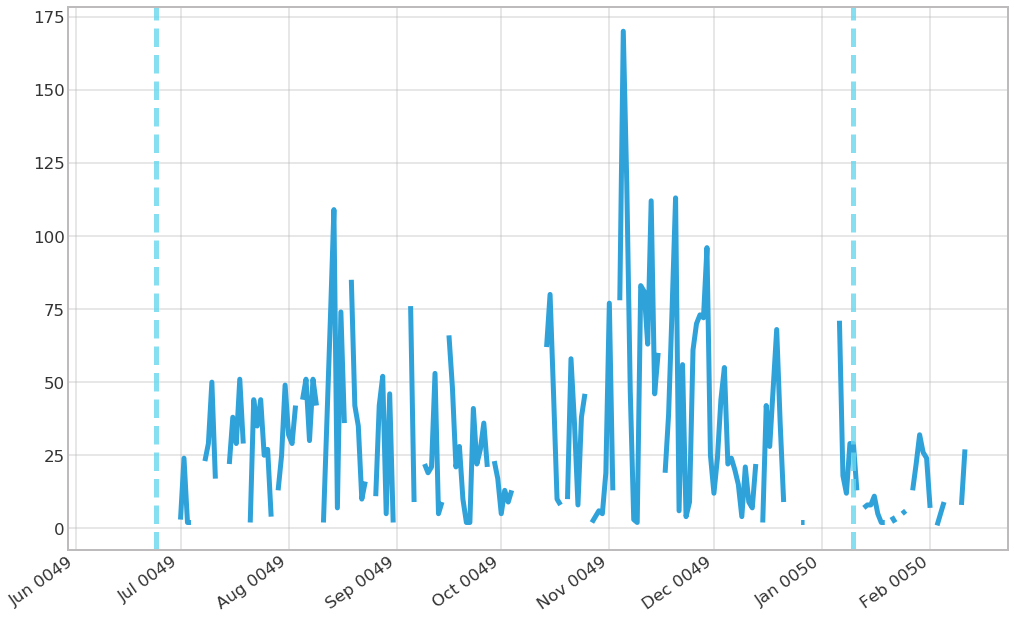

In [137]:
plt.figure(figsize=(15, 10))

df_day_issues['events_by_designsimply'].plot()
plot_designsimply_start_date()
plot_attrs_time()

Text(0,0.5,'Issue Actions by designsimply')

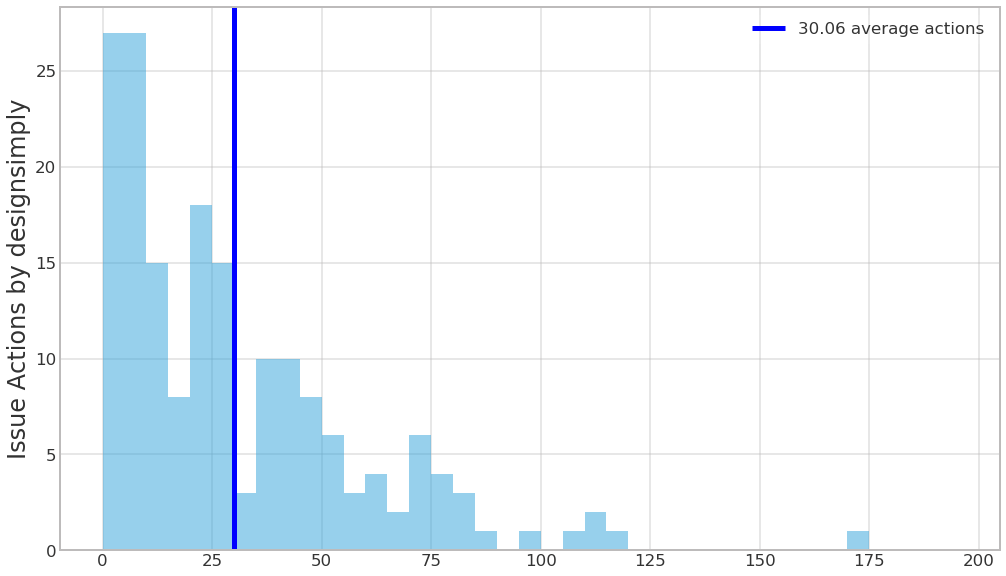

In [139]:
d1 = df_day_issues['events_by_designsimply']
d1.hist(bins=np.arange(0,200, 5), alpha=0.5,)
plt.axvline(
    d1.mean(),
    label='{:.2f} average actions'.format(d1.mean()),
    color='b',
)
plt.legend(loc=1)
plt.ylabel('Issue Actions by designsimply')

## Events by user

In [147]:
df_actor_issues_touched = (
    df_events
    .groupby([
        'event_created_at_date',
        'event_actor_username',
    ])
    ['event_issue_ext_id']
    .nunique()
    .unstack()   
)

Text(0,0.5,'Issues Acted Upon')

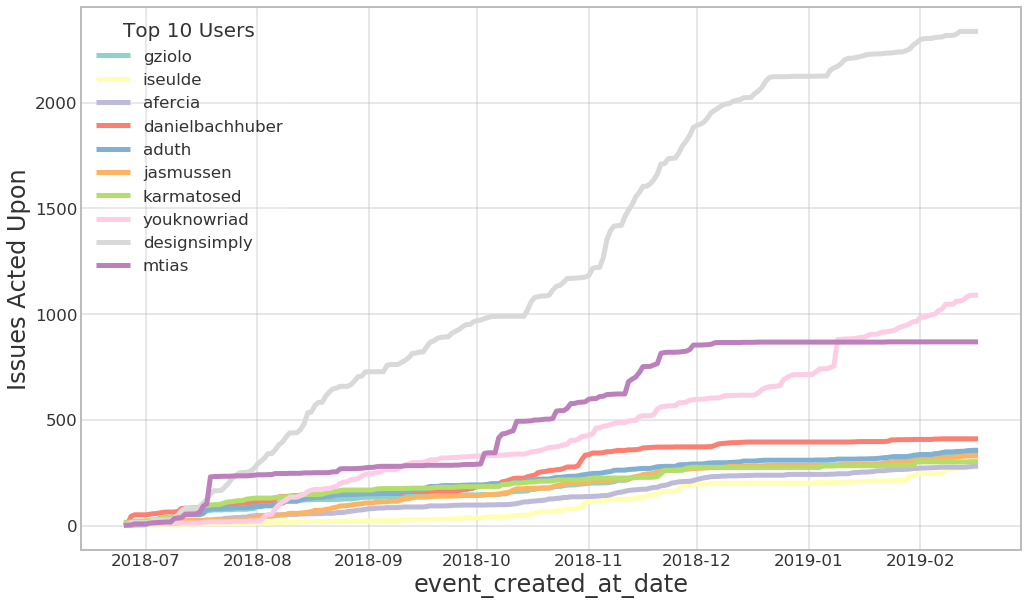

In [148]:
top_actors = df_actor_issues_touched.sum().sort_values()[-10:]
(
    df_actor_issues_touched
    .loc[DESIGNSIMPLY_START_DATE:, top_actors.index]
    .fillna(0)
    .cumsum(axis=0)
    .plot(
        color=sns.color_palette('Set3', len(top_actors)),
        legend=False,        
    )
)
plt.legend(title='Top 10 Users')
plt.ylabel("Issues Acted Upon")


## Bug Labels

In [156]:
df = (
    df_events
    .groupby('event_label')
    ['event_issue_ext_id']
    .nunique()
    .sort_values()
    .to_frame('issue_cnt')
)
df['issue_pct'] = df['issue_cnt'] / df['issue_cnt'].sum()
df

,issue_cnt,issue_pct
event_label,,
wontfix,1,0.000072
[Package] Autop,1,0.000072
[Component] Columns,1,0.000072
[Package] Babel plugin import JSX pragma,1,0.000072
[Package] Babel plugin makepot,1,0.000072
[Block] Verse,1,0.000072
[Package] DOM,1,0.000072
[Package] Deprecated,1,0.000072
[Package] ESLint plugin,1,0.000072


In [168]:
bug_issues = (
    df_events
    #.query('label_name == "[Type] Bug"')
    .query('event_label == "[Type] Help Request"')
    .groupby('event_issue_ext_id')
    ['event_created_at']
    .min()
    .to_frame('bug_label_created_at')
)

In [171]:
df_issues['bug_label_created_date'] = (
    df_issues[['issue_ext_id']]
    .merge(
        bug_issues,
        how='left',
        right_index=True,
        left_on='issue_ext_id',        
    )
    ['bug_label_created_at']
    .dt
    .date
)

In [172]:
df_issues['is_labeled_bug'] = ~df_issues['bug_label_created_date'].isnull()

In [173]:
df_day_bug_issues = calc_day_issues(df_issues.query('is_labeled_bug'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [174]:
df_day_bug_issues['issues_labeled_bug_cnt'] = (
    df_issues
    .groupby('bug_label_created_date')
    .size()
    
)

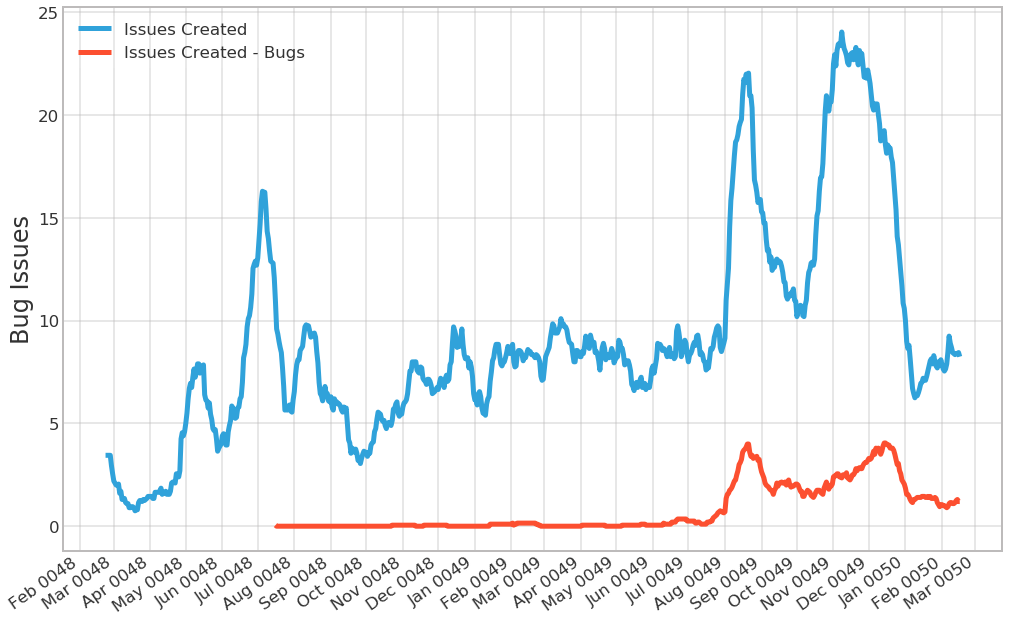

In [177]:
df_day_issues['issues_created_cnt'].rolling(20).mean().plot(
    label="Issues Created"
)
df_day_bug_issues['issues_created_cnt'].rolling(20).mean().plot(
    label="Issues Created - Bugs"
)
plt.legend()
plt.ylabel('Bug Issues')
plot_attrs_time()

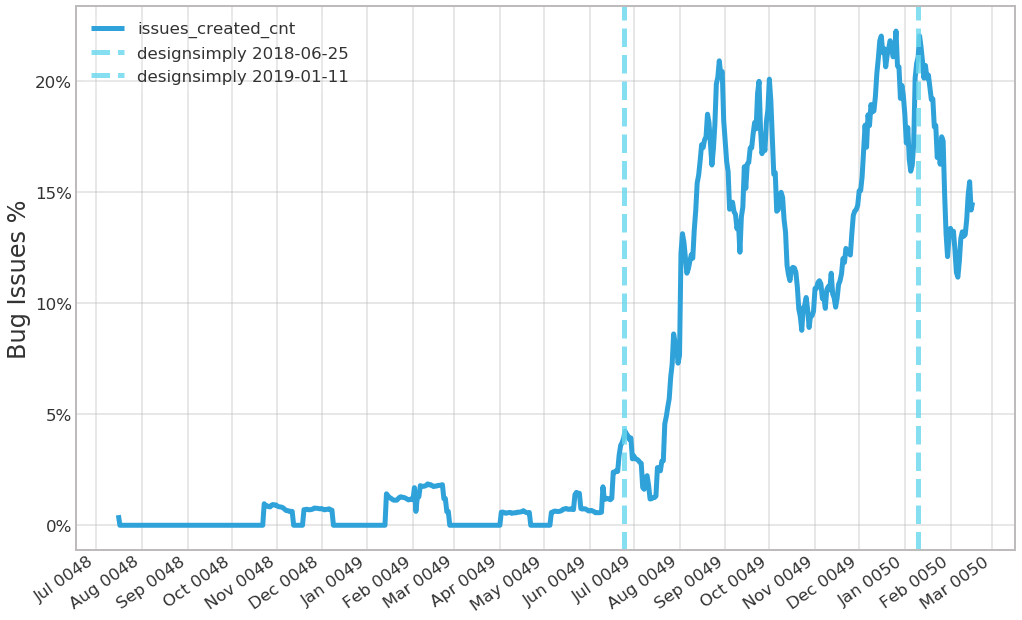

In [178]:
(
    df_day_bug_issues['issues_created_cnt'].rolling(20).mean() / df_day_issues['issues_created_cnt'].rolling(20).mean()
).plot()

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
plot_designsimply_start_date()
plt.legend()
plt.ylabel('Bug Issues %')
plot_attrs_time()

In [179]:
df_day_bug_issues['issues_open_cnt'] = (
    df_day_bug_issues['issues_created_cnt'].cumsum() - df_day_bug_issues['issues_closed_cnt'].cumsum()
)

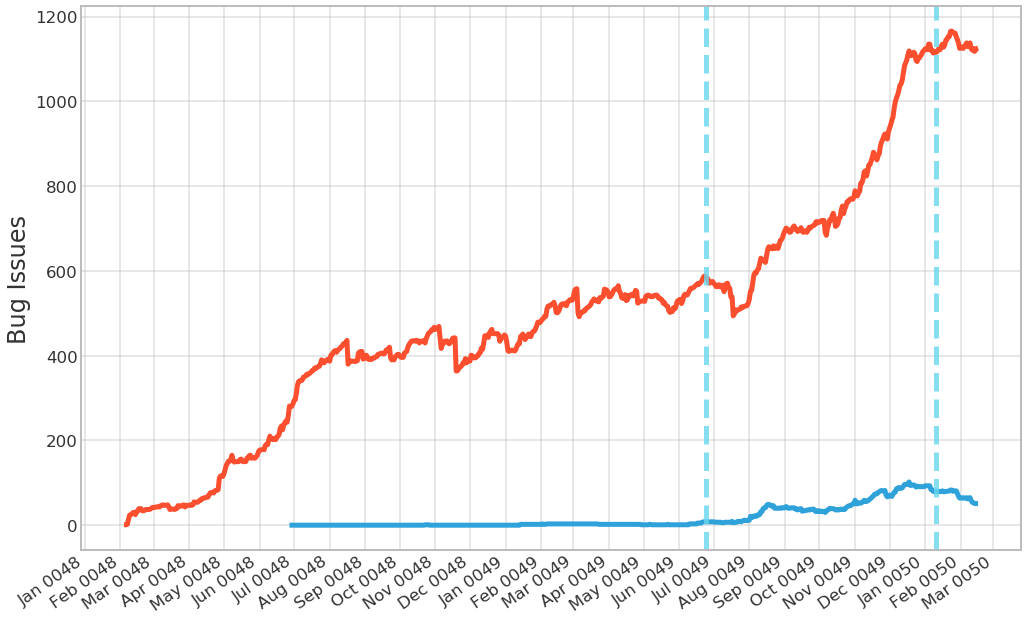

In [180]:
df_day_bug_issues['issues_open_cnt'].plot()
(df_day_issues['issues_created_cnt'].cumsum() - df_day_issues['issues_closed_cnt'].cumsum()).plot()

plt.ylabel('Bug Issues')
plot_designsimply_start_date()
plot_attrs_time()

## Help Requests

In [183]:
help_issues = (
    df_events
    #.query('label_name == "[Type] Bug"')
    .query('event_label == "[Type] Help Request"')
    .groupby('event_issue_ext_id')
    ['event_created_at']
    .min()
    .to_frame('help_label_created_at')
)

In [184]:
df_issues['help_label_created_date'] = (
    df_issues[['issue_ext_id']]
    .merge(
        help_issues,
        how='left',
        right_index=True,
        left_on='issue_ext_id',        
    )
    ['help_label_created_at']
    .dt
    .date

)

In [185]:
df_day_issues['issues_labeled_help_request_cnt'] = (
    df_issues
    .groupby('help_label_created_date')
    .size()
    
)

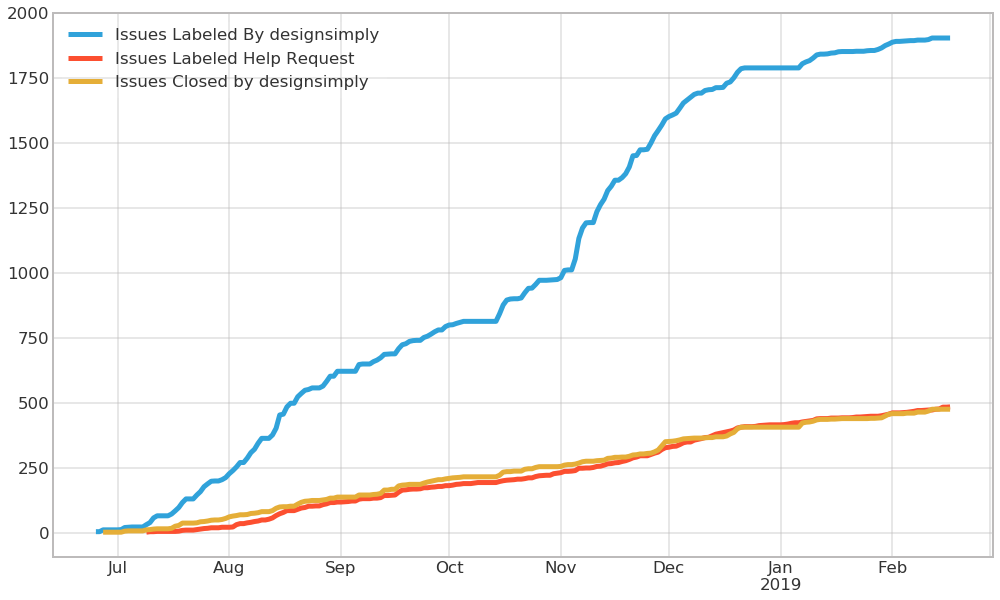

In [186]:
df_day_issues['issues_labeled_by_designsimply'].cumsum().fillna(method='ffill').plot(
    ls='-',
    label='Issues Labeled By designsimply',
)
df_day_issues['issues_labeled_help_request_cnt'].cumsum().fillna(method='ffill').plot(

    ls='-',
        label='Issues Labeled Help Request',

)
df_day_issues['issues_closed_by_designsimply'].cumsum().fillna(method='ffill').plot(
    ls='-',
    label='Issues Closed by designsimply',
)
plt.legend()
